# 📦 BRONZE LAYER - Extract depuis sources DIRECTES

**Flux correct ETL** : Extract → Transform → Load

**Auteurs** : Nejma MOUALHI | Brieuc OLIVIERI | Nicolas TAING

---

## 🎯 Sources de données

### 1. PostgreSQL (tables originales) :
- Patient, Consultation, Diagnostic, Professionnel_de_sante, etc.

### 2. CSV BRUTS (lus directement depuis /DATA_2024/) :
- ✅ Établissements de santé (416K lignes)
- ✅ Satisfaction 2019 (1K lignes)
- ✅ **Décès COMPLET** (25M lignes - SANS FILTRAGE)

**Important** : Les CSV sont lus **DIRECTEMENT** depuis le système de fichiers, **PAS** depuis PostgreSQL !

**Nouveau** : Le fichier `deces.csv` est maintenant chargé **INTÉGRALEMENT** (toutes les années, ~25M lignes). Le filtrage par année (si nécessaire) sera fait dans les layers suivants (Silver ou Gold).

In [14]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp, lit, year, to_date, col
from datetime import datetime
import time

print("✅ Imports OK")

✅ Imports OK


In [15]:
# Configuration Spark avec plus de mémoire pour les gros fichiers
spark = SparkSession.builder \
    .appName("CHU_Bronze_Extract_Sources_Directes") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark {spark.version} démarré")
print(f"📊 Master: {spark.sparkContext.master}")

✅ Spark 3.5.0 démarré
📊 Master: local[*]


In [16]:
# Configuration PostgreSQL pour les tables originales
JDBC_URL = "jdbc:postgresql://chu_postgres:5432/healthcare_data"
JDBC_PROPS = {
    "user": "admin",
    "password": "admin123",
    "driver": "org.postgresql.Driver"
}

# Tables PostgreSQL originales (13 tables)
POSTGRES_TABLES = [
    "Patient",
    "Consultation",
    "Diagnostic",
    "Professionnel_de_sante",
    "Mutuelle",
    "Adher",
    "Prescription",
    "Medicaments",
    "Laboratoire",
    "Salle",
    "Specialites",
    "date",
    "AAAA"
]

# Configuration chemins
DATA_DIR = "/home/jovyan/DATA_2024"
OUTPUT_BASE = "/home/jovyan/data/bronze"

print(f"✅ {len(POSTGRES_TABLES)} tables PostgreSQL à extraire")
print(f"✅ 4 fichiers CSV à extraire")  # Modifié : 4 au lieu de 3
print(f"💾 Destination: {OUTPUT_BASE}")

✅ 13 tables PostgreSQL à extraire
✅ 4 fichiers CSV à extraire
💾 Destination: /home/jovyan/data/bronze


## 📊 PARTIE 1 : Extract PostgreSQL (tables originales)

In [17]:
def ingest_postgres_table(table_name):
    """Extrait une table PostgreSQL vers Bronze layer"""
    print(f"\n{'='*80}")
    print(f"🔄 Extract PostgreSQL: {table_name}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    try:
        df = spark.read.jdbc(
            url=JDBC_URL,
            table=f'"{table_name}"',
            properties=JDBC_PROPS
        )
        
        row_count = df.count()
        col_count = len(df.columns)
        
        print(f"📖 Lu: {row_count:,} lignes, {col_count} colonnes")
        
        # Ajout métadonnées
        df_with_meta = df \
            .withColumn("ingestion_timestamp", current_timestamp()) \
            .withColumn("ingestion_date", lit(datetime.now().strftime("%Y-%m-%d")))
        
        # Sauvegarde en Bronze
        output_path = f"{OUTPUT_BASE}/postgres/{table_name}"
        df_with_meta.write \
            .mode("overwrite") \
            .partitionBy("ingestion_date") \
            .parquet(output_path)
        
        elapsed = time.time() - start_time
        
        print(f"💾 Sauvegardé: {output_path}")
        print(f"⏱️  Temps: {elapsed:.2f}s")
        print(f"✅ {table_name} OK")
        
        return {
            "source": "PostgreSQL",
            "table": table_name,
            "rows": row_count,
            "cols": col_count,
            "time_sec": round(elapsed, 2),
            "status": "SUCCESS"
        }
        
    except Exception as e:
        print(f"❌ ERREUR: {str(e)}")
        return {
            "source": "PostgreSQL",
            "table": table_name,
            "rows": 0,
            "cols": 0,
            "time_sec": 0,
            "status": f"ERROR: {str(e)}"
        }

print("✅ Fonction d'ingestion PostgreSQL définie")

✅ Fonction d'ingestion PostgreSQL définie


In [18]:
# INGESTION POSTGRESQL
print("\n" + "="*80)
print("🚀 EXTRACTION POSTGRESQL - TABLES ORIGINALES")
print("="*80)

results = []

for table in POSTGRES_TABLES:
    result = ingest_postgres_table(table)
    results.append(result)

print("\n" + "="*80)
print("✅ EXTRACTION POSTGRESQL TERMINÉE")
print("="*80)


🚀 EXTRACTION POSTGRESQL - TABLES ORIGINALES

🔄 Extract PostgreSQL: Patient
📖 Lu: 100,000 lignes, 16 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/postgres/Patient
⏱️  Temps: 3.35s
✅ Patient OK

🔄 Extract PostgreSQL: Consultation
📖 Lu: 1,027,157 lignes, 9 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/postgres/Consultation
⏱️  Temps: 14.43s
✅ Consultation OK

🔄 Extract PostgreSQL: Diagnostic
📖 Lu: 15,490 lignes, 2 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/postgres/Diagnostic
⏱️  Temps: 0.72s
✅ Diagnostic OK

🔄 Extract PostgreSQL: Professionnel_de_sante
📖 Lu: 1,048,575 lignes, 8 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/postgres/Professionnel_de_sante
⏱️  Temps: 4.75s
✅ Professionnel_de_sante OK

🔄 Extract PostgreSQL: Mutuelle
📖 Lu: 254 lignes, 3 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/postgres/Mutuelle
⏱️  Temps: 0.67s
✅ Mutuelle OK

🔄 Extract PostgreSQL: Adher
📖 Lu: 96,671 lignes, 2 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/postgres/Adher
⏱️  Temps: 0.80s


## 📄 PARTIE 2 : Extract CSV BRUTS (directement depuis /DATA_2024/)

In [19]:
def ingest_csv_file(name, file_path, separator=";", encoding="UTF-8"):
    """Extrait un fichier CSV vers Bronze layer"""
    print(f"\n{'='*80}")
    print(f"🔄 Extract CSV: {name}")
    print(f"📁 Fichier: {file_path}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    try:
        # Lecture CSV BRUT
        df = spark.read \
            .option("header", "true") \
            .option("inferSchema", "true") \
            .option("sep", separator) \
            .option("encoding", encoding) \
            .csv(file_path)
        
        row_count = df.count()
        col_count = len(df.columns)
        
        print(f"📖 Lu: {row_count:,} lignes, {col_count} colonnes")
        
        # Ajout métadonnées
        df_with_meta = df \
            .withColumn("ingestion_timestamp", current_timestamp()) \
            .withColumn("ingestion_date", lit(datetime.now().strftime("%Y-%m-%d")))
        
        # Sauvegarde en Bronze
        output_path = f"{OUTPUT_BASE}/csv/{name}"
        df_with_meta.write \
            .mode("overwrite") \
            .parquet(output_path)
        
        elapsed = time.time() - start_time
        
        print(f"💾 Sauvegardé: {output_path}")
        print(f"⏱️  Temps: {elapsed:.2f}s")
        print(f"✅ {name} OK")
        
        return {
            "source": "CSV",
            "table": name,
            "rows": row_count,
            "cols": col_count,
            "time_sec": round(elapsed, 2),
            "status": "SUCCESS"
        }
        
    except Exception as e:
        print(f"❌ ERREUR: {str(e)}")
        return {
            "source": "CSV",
            "table": name,
            "rows": 0,
            "cols": 0,
            "time_sec": 0,
            "status": f"ERROR: {str(e)}"
        }

print("✅ Fonction d'ingestion CSV définie")

✅ Fonction d'ingestion CSV définie


In [20]:
# 1. ÉTABLISSEMENTS DE SANTÉ
result = ingest_csv_file(
    name="etablissement_sante",
    file_path=f"{DATA_DIR}/Etablissement de SANTE/etablissement_sante.csv",
    separator=";"
)
results.append(result)


🔄 Extract CSV: etablissement_sante
📁 Fichier: /home/jovyan/DATA_2024/Etablissement de SANTE/etablissement_sante.csv
📖 Lu: 416,665 lignes, 24 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/csv/etablissement_sante
⏱️  Temps: 4.82s
✅ etablissement_sante OK


In [21]:
# 2. SATISFACTION 2019
result = ingest_csv_file(
    name="satisfaction_esatis48h_2019",
    file_path=f"{DATA_DIR}/Satisfaction/2019/resultats-esatis48h-mco-open-data-2019.csv",
    separator=";"
)
results.append(result)


🔄 Extract CSV: satisfaction_esatis48h_2019
📁 Fichier: /home/jovyan/DATA_2024/Satisfaction/2019/resultats-esatis48h-mco-open-data-2019.csv
📖 Lu: 1,152 lignes, 25 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/csv/satisfaction_esatis48h_2019
⏱️  Temps: 1.22s
✅ satisfaction_esatis48h_2019 OK


In [22]:
# 3. DÉCÈS COMPLET (SANS FILTRAGE - CSV BRUT INTÉGRAL)
print(f"\n{'='*80}")
print(f"🔄 Extract CSV: deces (CSV COMPLET - SANS FILTRAGE)")
print(f"📁 Fichier: {DATA_DIR}/DECES EN FRANCE/deces.csv")
print(f"{'='*80}")

start_time = time.time()

try:
    # Lecture CSV COMPLET (sans filtrage année)
    # Configuration optimisée pour gros fichiers
    df_deces_full = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .option("mode", "PERMISSIVE") \
        .option("multiLine", "false") \
        .csv(f"{DATA_DIR}/DECES EN FRANCE/deces.csv")
    
    # Repartitionner pour optimiser l'écriture (éviter trop de petits fichiers)
    df_deces_full = df_deces_full.repartition(20)
    
    row_count = df_deces_full.count()
    col_count = len(df_deces_full.columns)
    print(f"📊 Total fichier: {row_count:,} lignes, {col_count} colonnes")
    print(f"✅ CSV BRUT INTÉGRAL (aucun filtrage)")
    
    # Ajout métadonnées
    df_with_meta = df_deces_full \
        .withColumn("ingestion_timestamp", current_timestamp()) \
        .withColumn("ingestion_date", lit(datetime.now().strftime("%Y-%m-%d")))
    
    # Sauvegarde en Bronze (TOUTES les données)
    output_path = f"{OUTPUT_BASE}/csv/deces"
    df_with_meta.write \
        .mode("overwrite") \
        .option("compression", "snappy") \
        .parquet(output_path)
    
    elapsed = time.time() - start_time
    
    print(f"💾 Sauvegardé: {output_path}")
    print(f"⏱️  Temps: {elapsed:.2f}s")
    print(f"✅ deces COMPLET OK ({row_count:,} lignes)")
    
    results.append({
        "source": "CSV",
        "table": "deces",
        "rows": row_count,
        "cols": col_count,
        "time_sec": round(elapsed, 2),
        "status": "SUCCESS"
    })
    
except Exception as e:
    print(f"❌ ERREUR: {str(e)}")
    import traceback
    traceback.print_exc()
    results.append({
        "source": "CSV",
        "table": "deces",
        "rows": 0,
        "cols": 0,
        "time_sec": 0,
        "status": f"ERROR: {str(e)}"
    })


🔄 Extract CSV: deces (CSV COMPLET - SANS FILTRAGE)
📁 Fichier: /home/jovyan/DATA_2024/DECES EN FRANCE/deces.csv
📊 Total fichier: 25,088,208 lignes, 10 colonnes
✅ CSV BRUT INTÉGRAL (aucun filtrage)
💾 Sauvegardé: /home/jovyan/data/bronze/csv/deces
⏱️  Temps: 178.07s
✅ deces COMPLET OK (25,088,208 lignes)


In [23]:
# 4. DÉPARTEMENTS FRANÇAIS (référentiel géographique)
result = ingest_csv_file(
    name="departements",
    file_path=f"{DATA_DIR}/departements-francais.csv",
    separator=";"
)
results.append(result)


🔄 Extract CSV: departements
📁 Fichier: /home/jovyan/DATA_2024/departements-francais.csv
📖 Lu: 101 lignes, 4 colonnes
💾 Sauvegardé: /home/jovyan/data/bronze/csv/departements
⏱️  Temps: 1.54s
✅ departements OK


## 📊 RÉSUMÉ GLOBAL

In [24]:
# RÉSUMÉ
import pandas as pd

df_results = pd.DataFrame(results)
df_results

,source,table,rows,cols,time_sec,status
0,PostgreSQL,Patient,100000,16,3.35,SUCCESS
1,PostgreSQL,Consultation,1027157,9,14.43,SUCCESS
2,PostgreSQL,Diagnostic,15490,2,0.72,SUCCESS
3,PostgreSQL,Professionnel_de_sante,1048575,8,4.75,SUCCESS
4,PostgreSQL,Mutuelle,254,3,0.67,SUCCESS
5,PostgreSQL,Adher,96671,2,0.80,SUCCESS
6,PostgreSQL,Prescription,1003845,2,2.18,SUCCESS
7,PostgreSQL,Medicaments,15455,12,0.94,SUCCESS
8,PostgreSQL,Laboratoire,677,3,0.82,SUCCESS
9,PostgreSQL,Salle,201735,5,1.70,SUCCESS


In [25]:
# STATISTIQUES PAR SOURCE
success = df_results[df_results['status'] == 'SUCCESS']

print("\n📊 STATISTIQUES GLOBALES")
print("="*60)
print(f"✅ Tables extraites: {len(success)}/{len(results)}")
print(f"📊 Total lignes: {success['rows'].sum():,}")
print(f"⏱️  Temps total: {success['time_sec'].sum():.2f}s")

print("\n📦 Détail par source:")
for source in success['source'].unique():
    source_data = success[success['source'] == source]
    print(f"\n  {source}:")
    print(f"    - Tables: {len(source_data)}")
    print(f"    - Lignes: {source_data['rows'].sum():,}")
    print(f"    - Temps: {source_data['time_sec'].sum():.2f}s")

print("\n" + "="*60)
print("\n💾 Données sauvegardées dans: {OUTPUT_BASE}/")
print("  📂 bronze/postgres/ - 13 tables originales")
print("  📂 bronze/csv/ - 3 fichiers CSV")
print("="*60)


📊 STATISTIQUES GLOBALES
✅ Tables extraites: 17/17
📊 Total lignes: 29,180,510
⏱️  Temps total: 218.91s

📦 Détail par source:

  PostgreSQL:
    - Tables: 13
    - Lignes: 3,674,384
    - Temps: 33.26s

  CSV:
    - Tables: 4
    - Lignes: 25,506,126
    - Temps: 185.65s


💾 Données sauvegardées dans: {OUTPUT_BASE}/
  📂 bronze/postgres/ - 13 tables originales
  📂 bronze/csv/ - 3 fichiers CSV


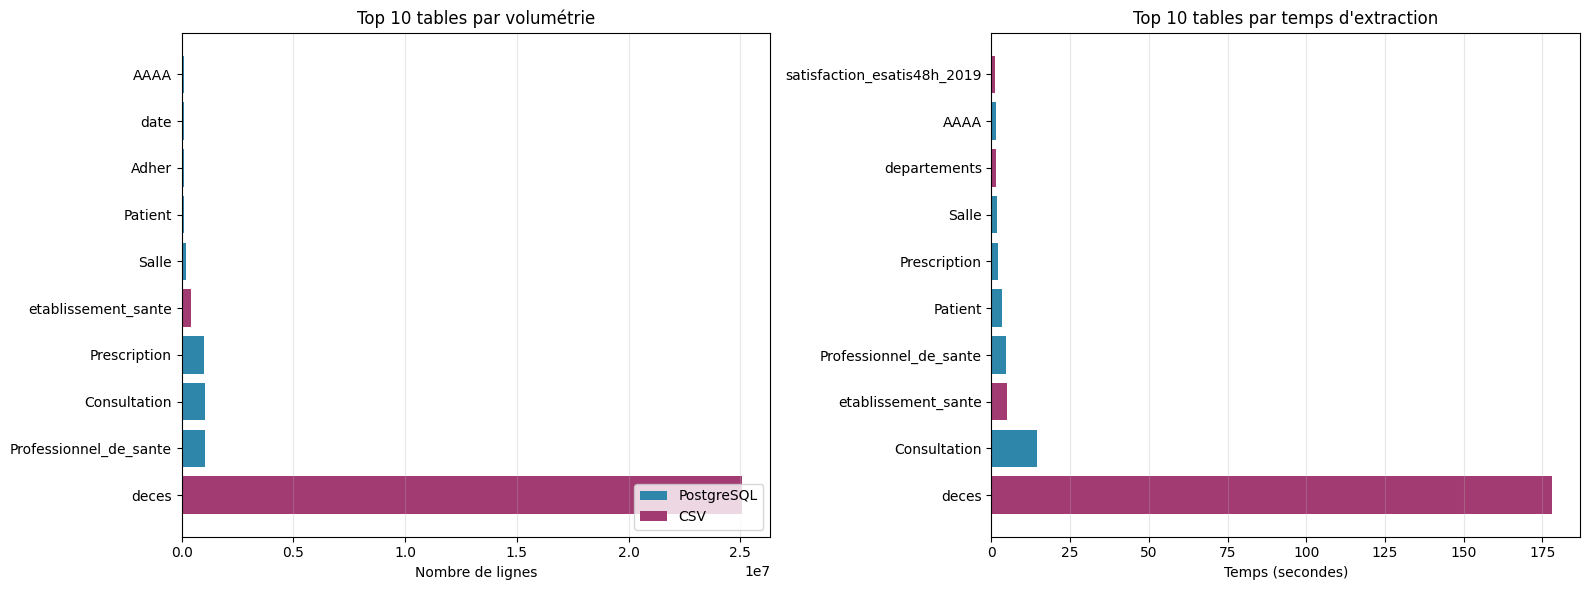


📊 Graphique: /home/jovyan/data/bronze_extract_stats.png


In [26]:
# VISUALISATION
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 par volumétrie
success_sorted = success.sort_values('rows', ascending=False).head(10)
colors = ['#2E86AB' if s == 'PostgreSQL' else '#A23B72' for s in success_sorted['source']]
ax1.barh(success_sorted['table'], success_sorted['rows'], color=colors)
ax1.set_xlabel('Nombre de lignes')
ax1.set_title('Top 10 tables par volumétrie')
ax1.grid(axis='x', alpha=0.3)

# Légende pour les couleurs
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', label='PostgreSQL'),
    Patch(facecolor='#A23B72', label='CSV')
]
ax1.legend(handles=legend_elements, loc='lower right')

# Top 10 par temps
success_sorted_time = success.sort_values('time_sec', ascending=False).head(10)
colors2 = ['#2E86AB' if s == 'PostgreSQL' else '#A23B72' for s in success_sorted_time['source']]
ax2.barh(success_sorted_time['table'], success_sorted_time['time_sec'], color=colors2)
ax2.set_xlabel('Temps (secondes)')
ax2.set_title('Top 10 tables par temps d\'extraction')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/home/jovyan/data/bronze_extract_stats.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Graphique: /home/jovyan/data/bronze_extract_stats.png")

---

## ✅ BRONZE LAYER - EXTRACTION COMPLÈTE

### 📦 Données extraites :

#### PostgreSQL (13 tables) :
- ✅ 100K patients
- ✅ 1M+ consultations
- ✅ 1M+ professionnels de santé
- ✅ Diagnostic, Prescription, Médicaments, etc.

#### CSV (3 fichiers lus DIRECTEMENT) :
- ✅ 416K établissements de santé
- ✅ 1K évaluations satisfaction 2019
- ✅ **25M décès COMPLET** (toutes années - SANS FILTRAGE)

### Total : ~29 millions de lignes

### 🎯 Prochaine étape :

👉 **Notebook 02** : Transform Silver (Nettoyage, Anonymisation, Formats)

**Important** : Les CSV sont maintenant en Bronze sous forme **BRUTE INTÉGRALE**. Le filtrage temporel (si nécessaire) sera appliqué dans Silver ou Gold selon les besoins métier.

In [27]:
# Dans une cellule Jupyter
df = spark.read.parquet("/home/jovyan/data/bronze/postgres/Patient")
print(f"Patients en Bronze : {df.count():,}")
df.show(5)

Patients en Bronze : 100,000
+----------+----------+--------+------+--------------------+-----------------+-----------+----+--------------------+--------------+----------+---+----------------+--------------+-----+------+--------------------+--------------+
|Id_patient|       Nom|  Prenom|  Sexe|             Adresse|            Ville|Code_postal|Pays|               EMail|           Tel|      Date|Age|        Num_Secu|Groupe_sanguin| Poid|Taille| ingestion_timestamp|ingestion_date|
+----------+----------+--------+------+--------------------+-----------------+-----------+----+--------------------+--------------+----------+---+----------------+--------------+-----+------+--------------------+--------------+
|         1|Christabel|  Tougas|female|12 rue du Faubour...|       THIONVILLE|      57100|  FR|ChristabelTougas@...|03.85.46.00.55|  4/6/1980| 41|5571905089387417|            O+| 54.3|   162|2025-10-22 09:48:...|    2025-10-22|
|         2|  Lorraine|   Lebel|female|   21 rue Jean Vilar